# Transformer

[paper](https://arxiv.org/pdf/1706.03762.pdf)

## Model

In [1]:
import torch
from torch import nn

In [2]:
# Tokenizer - Pretrained general purpose tokenizer
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Test
tokenized_test = tokenizer("Hello, I am a sentence.")
print(tokenized_test)
untokenized_test = tokenizer.decode(tokenized_test["input_ids"])
print(untokenized_test)

tokenizer.pad_token = tokenizer.eos_token 
tokenizer.eos_token, tokenizer.vocab_size

{'input_ids': [15496, 11, 314, 716, 257, 6827, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}
Hello, I am a sentence.


('<|endoftext|>', 50257)

In [3]:
tokenizer.eos_token 

'<|endoftext|>'

torch.Size([1, 100, 20])


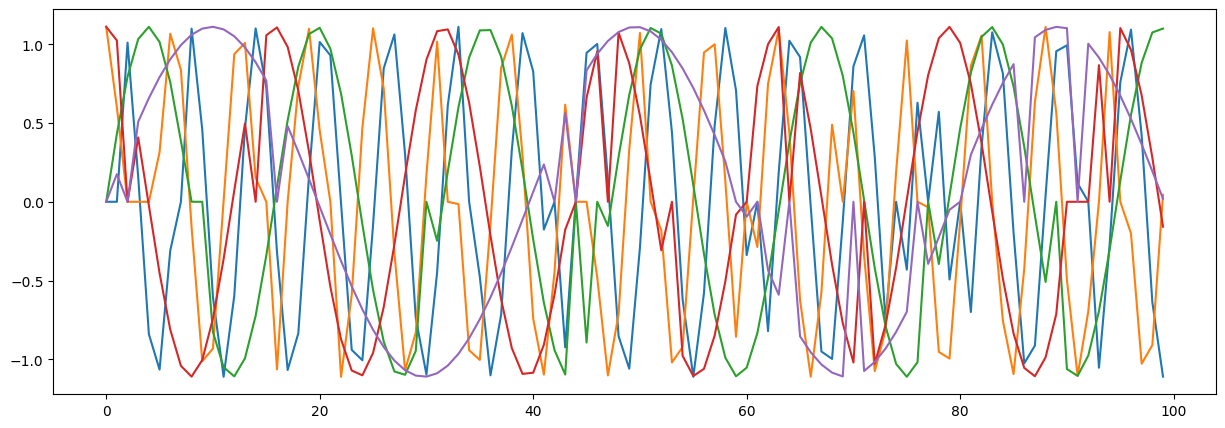

In [4]:
# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# Test
pe = PositionalEncoding(20)
x = torch.zeros(1, 100, 20)
y = pe(x)
print(y.size())

# Plot a single sample first 5 dimensions
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(y[0, :, :5].data.numpy())
plt.show()

In [5]:
!pip install -q ninja packaging
!MAX_JOBS=4 pip install -q flash-attn --no-build-isolation

from flash_attn import flash_attn_func

In [6]:
import torch
assert torch.cuda.get_device_capability()[0] >= 8, 'Hardware not supported for Flash Attention'


In [7]:
# Multi Head attention scaled dot product

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        original_size = q.size()
        
        # Linear transformation
        q = self.W_q(q)
        k = self.W_k(k)
        v = self.W_v(v)

        # Split into multiple heads
        q = q.view(batch_size, -1, self.num_heads, self.d_k)
        k = k.view(batch_size, -1, self.num_heads, self.d_k)
        v = v.view(batch_size, -1, self.num_heads, self.d_k)
        
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        # # Scaled dot product
        # scores = torch.matmul(q, k.transpose(-2, -1)) / (self.d_k ** 0.5)
        # if mask is not None:
        #     mask = mask.unsqueeze(1)
        #     scores = scores.masked_fill(mask == 0, -1e9)
        # scores = torch.nn.functional.softmax(scores, dim=-1)

        # # Weighted sum
        # output = torch.matmul(scores, v)
        # output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        output = flash_attn_func(q=q.half(), k=k.half(), v=v.half(),  dropout_p=0.1).float().contiguous().view(original_size)

        
        # Linear transformation
        output = self.W_o(output)
        
        return output
    
# Test
mha = MultiHeadAttention(512, 8).to('cuda')
q = torch.rand(64, 10, 512).to('cuda')
k = torch.rand(64, 10, 512).to('cuda')
v = torch.rand(64, 10, 512).to('cuda')
output = mha(q, k, v)
print(output.size())

torch.Size([64, 10, 512])


In [8]:
# Encoder Layer and Decoder Layer

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_hidden, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_hidden),
            nn.ReLU(),
            nn.Linear(ff_hidden, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask):
        # print(x.size())
        # print(f"mha: {self.mha(x, x, x, mask).size()}")
        x = x + self.dropout(self.mha(x, x, x, mask))
        x = self.norm1(x)
        x = x + self.dropout(self.ff(x))
        x = self.norm2(x)
        return x
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_hidden, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_hidden),
            nn.ReLU(),
            nn.Linear(ff_hidden, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        x = x + self.dropout(self.mha1(x, x, x, look_ahead_mask))
        x = self.norm1(x)
        x = x + self.dropout(self.mha2(x, enc_output, enc_output, padding_mask))
        x = self.norm2(x)
        x = x + self.dropout(self.ff(x))
        x = self.norm3(x)
        return x

# Test
encoder_layer = EncoderLayer(512, 8, 2048).to('cuda')
x = torch.rand(64, 10, 512).to('cuda')
output = encoder_layer(x, None)
print(output.size())

torch.Size([64, 10, 512])


In [9]:
# Transformer
from torch.cuda.amp import autocast

class Transformer(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, ff_hidden, vocab_size, max_len, dropout=0.1):
        super(Transformer, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout, max_len)
        self.encoder = nn.ModuleList([EncoderLayer(d_model, num_heads, ff_hidden, dropout) for _ in range(num_layers)])
        self.decoder = nn.ModuleList([DecoderLayer(d_model, num_heads, ff_hidden, dropout) for _ in range(num_layers)])
        self.fc = nn.Linear(d_model, vocab_size)
    
    @autocast()  # Decorator to enable automatic mixed precision
    def forward(self, src, tgt, src_mask, tgt_mask):
        src = self.pos_enc(self.embedding(src))
        tgt = self.pos_enc(self.embedding(tgt))
        
        i = 0
        for layer in self.encoder:
            # print("layer ", i)
            src = layer(src, src_mask)
        
        for layer in self.decoder:
            tgt = layer(tgt, src, tgt_mask, src_mask)
        
        return self.fc(tgt)

## Dataset

We are going to use a big one as we are going to leverage the power of huggingface datasets library.

In [10]:
import datasets

dataset_train = datasets.load_dataset("EleutherAI/the_pile_deduplicated", streaming=True, split="train", trust_remote_code=True).with_format("torch")

print(next(iter(dataset_train))["text"])

Resolving data files:   0%|          | 0/1650 [00:00<?, ?it/s]

It is done, and submitted. You can play “Survival of the Tastiest” on Android, and on the web. Playing on the web works, but you have to simulate multi-touch for table moving and that can be a bit confusing.

There’s a lot I’d like to talk about. I’ll go through every topic, insted of making the typical what went right/wrong list.

Concept

Working over the theme was probably one of the hardest tasks I had to face.

Originally, I had an idea of what kind of game I wanted to develop, gameplay wise – something with lots of enemies/actors, simple graphics, maybe set in space, controlled from a top-down view. I was confident I could fit any theme around it.

In the end, the problem with a theme like “Evolution” in a game is that evolution is unassisted. It happens through several seemingly random mutations over time, with the most apt permutation surviving. This genetic car simulator is, in my opinion, a great example of actual evolution of a species facing a challenge. But is it a game?



In [11]:
# # Dataset

# # We are going to use a big one as we are going to leverage the power of huggingface datasets library.

# import datasets

# # Let's load the dataset
# dataset_train = datasets.load_dataset("yahoo_answers_topics", streaming=True, split="train", trust_remote_code=True).with_format("torch")
# dataset_test = datasets.load_dataset("yahoo_answers_topics", streaming=True, split="test", trust_remote_code=True).with_format("torch")

# # dataset_train = dataset_train.to_iterable_dataset(num_shards=64)
# # dataset_test = dataset_test.to_iterable_dataset(num_shards=64)

# # Let's check the first example
# print(next(iter(dataset_train)))

In [12]:
# # https://huggingface.co/datasets/yahoo_answers_topics/blob/main/README.md
# total_train_size = 1400000
# total_test_size = 60000

# reduction_factor = 4

# dataset_train = dataset_train.take(total_train_size // reduction_factor)
# dataset_test = dataset_test.skip(total_test_size // reduction_factor).take(total_test_size // reduction_factor)

# train_size = total_train_size // reduction_factor
# test_size = total_test_size // reduction_factor

In [13]:
MAX_LEN = 1024

def preprocess(example):
    # print(len(example['best_answer']))
    return {
            'text': tokenizer(example['text'], return_tensors="pt", padding='max_length', truncation=True, max_length=MAX_LEN)["input_ids"],
        }



# Let's apply the function to the dataset
dataset_train = dataset_train.map(preprocess)
# dataset_test = dataset_test.map(preprocess)

# Let's check the first example
print(next(iter(dataset_train)))


{'text': tensor([[1026,  318, 1760,  ..., 1088,  838, 4201]])}


/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


In [14]:
# # Define prompt and response

# # We are going to concatenate the title and the question as the prompt and the best answer as the response.
# MAX_LEN = 1024

# def preprocess(example):
#     # print(len(example['best_answer']))
#     return {
#             'id': example['id'],
#             'topic': example['topic'], 
#             'prompt': tokenizer(f"{example['question_title']} {example['question_content']}", return_tensors="pt", padding='max_length', truncation=True, max_length=MAX_LEN)["input_ids"],
#             'response': tokenizer(example['best_answer'], return_tensors="pt", padding='max_length', truncation=True, max_length=MAX_LEN)["input_ids"]
#         }

# # Let's apply the function to the dataset
# dataset_train = dataset_train.map(preprocess, remove_columns=["question_title", "question_content", "best_answer"])
# dataset_test = dataset_test.map(preprocess, remove_columns=["question_title", "question_content", "best_answer"])

# # Let's check the first example
# print(next(iter(dataset_train)))


In [15]:
dataset_train.n_shards

1650

In [16]:
dataset_size = dataset_train.info.dataset_size

In [17]:
WANTED_NUM_TOKENS = 500 * 1000 * 1000
total_train_size = WANTED_NUM_TOKENS // (MAX_LEN * 2)
total_test_size = total_train_size // 10

train_size = total_train_size
test_size = total_test_size

total_train_size, total_test_size

(244140, 24414)

In [18]:
# dataset_test = dataset_train.take(total_test_size)
# dataset_train = dataset_train.skip(total_test_size).take(total_train_size)
dataset_train = dataset_train.take(total_train_size)

# dataset_train.n_shards, dataset_test.n_shards
dataset_train.n_shards

1650

In [19]:
BATCH_SIZE = 8

def collate_fn(examples):
    return {
        'text': torch.stack([example['text'] for example in examples]),
    }

# DataLoader
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, pin_memory=True, num_workers=4, collate_fn=collate_fn)
# test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, pin_memory=True, num_workers=4, collate_fn=collate_fn)

# Test
for batch in train_loader:
    print(batch)
    break


/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

{'text': tensor([[[ 1026,   318,  1760,  ...,  1088,   838,  4201]],

        [[33221,    25, 36608,  ..., 50256, 50256, 50256]],

        [[ 8585,  5675, 30382,  ..., 50256, 50256, 50256]],

        ...,

        [[   90,   198,   220,  ..., 50256, 50256, 50256]],

        [[28768,   198,   198,  ..., 50256, 50256, 50256]],

        [[   73,  6684,    48,  ...,   355,   880,   355]]])}


In [20]:
# BATCH_SIZE = 8

# def collate_fn(examples):
#     print([example['prompt'].size() for example in examples], [example['response'].size() for example in examples])
#     return {
#         'id': [example['id'] for example in examples],
#         'topic': [example['topic'] for example in examples],
#         'prompt': torch.stack([example['prompt'] for example in examples]),
#         'response': torch.stack([example['response'] for example in examples])
    
#     }

# # DataLoader
# train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, pin_memory=True, num_workers=4, collate_fn=collate_fn)
# test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, pin_memory=True, num_workers=4, collate_fn=collate_fn)

# # Test
# for batch in train_loader:
#     print(batch)
#     break

In [21]:
i = 0
for batch in train_loader:
    i += 1
    if i == 10:
        break

/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

In [22]:
# Test Transformer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
D_MODEL = 256
transformer = Transformer(num_layers=6, d_model=D_MODEL, num_heads=8, ff_hidden=2048, vocab_size=tokenizer.vocab_size, max_len=MAX_LEN).to(device)
sample = next(iter(dataset_train))
src = sample["text"].to(device)
tgt = src.clone().to(device)

print(src.size(), tgt.size())
out = transformer(src, tgt, None, None)
print(out.size())

torch.Size([1, 1024]) torch.Size([1, 1024])
torch.Size([1, 1024, 50257])


In [23]:
# # Test Transformer

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# D_MODEL = 256
# transformer = Transformer(num_layers=6, d_model=D_MODEL, num_heads=8, ff_hidden=2048, vocab_size=tokenizer.vocab_size, max_len=MAX_LEN).to(device)
# sample = next(iter(dataset_train))
# src, tgt = batch["prompt"].to(device), batch["response"].to(device)

# print(src.size(), tgt.size())
# out = transformer(src, tgt, None, None)
# print(out.size())

In [24]:
# out.argmax(dim=-1)

In [25]:
# tokenizer.decode(out.argmax(dim=-1)[0])

In [26]:
# Masking
def create_mask(src, tgt):
    src_mask = (src != 0).unsqueeze(-2)
    tgt_mask = (tgt != 0).unsqueeze(-2)
    tgt_mask = tgt_mask & torch.autograd.Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return src_mask, tgt_mask

def subsequent_mask(size):
    mask = torch.ones(size, size).triu(1)
    return mask

src_mask, tgt_mask = create_mask(src, tgt)
out = transformer(src, tgt, src_mask, tgt_mask)
print(out.size())

torch.Size([1, 1024, 50257])


In [27]:
!pip install -q torch_optimizer

In [28]:
# Loss
import torch.nn.functional as F
import torch.optim as optim

# Use AdaFactor as optimizer from torch_optim
from torch_optimizer.adafactor import Adafactor

# optimizer = optim.Adam(transformer.parameters(), lr=0.0001)
optimizer = Adafactor(transformer.parameters())
criterion = F.cross_entropy

In [29]:
# Clear cache
# torch.cuda.empty_cache()

In [30]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# transformer = Transformer(num_layers=4, d_model=D_MODEL, num_heads=4, ff_hidden=1024, vocab_size=tokenizer.vocab_size, max_len=MAX_LEN).to(device)


In [31]:
# # Training
# transformer.train()

# for batch in train_loader:
#     src = batch['prompt'].to(device)
#     tgt = batch['response'].to(device)
#     src_mask, tgt_mask = create_mask(src, tgt)
#     optimizer.zero_grad()
#     out = transformer(src, tgt, src_mask, tgt_mask)
#     # out = transformer(src, tgt, None, None)
#     loss = criterion(out.view(-1, out.size(-1)), tgt.view(-1))
#     loss.backward()
#     optimizer.step()
#     print(loss.item())
#     break

# # Evaluation
# transformer.eval()

# for batch in test_loader:
#     src = batch['prompt'].to(device)
#     tgt = batch['response'].to(device)
#     src_mask, tgt_mask = create_mask(src, tgt)
#     out = transformer(src, tgt, src_mask, tgt_mask)
#     # out = transformer(src, tgt, None, None)
#     loss = criterion(out.view(-1, out.size(-1)), tgt.view(-1))
#     print(loss.item())
#     break


# # Inference
# transformer.eval()

# sample = next(iter(dataset_test))
# src = batch['prompt'].to(device)
# tgt = batch['response'].to(device)
# src_mask, tgt_mask = create_mask(src, tgt)
# out = transformer(src, tgt, src_mask, tgt_mask)
# tokenizer.decode(out.argmax(dim=-1)[0][0])


# Accelerate

In [32]:
!pip install -q accelerate

In [33]:

from tqdm import tqdm
from accelerate import Accelerator
from matplotlib import pyplot as plt
# accelerator = Accelerator(mixed_precision='fp16')

# device = accelerator.device
# optimizer.zero_grad()
# transformer, optimizer, train_loader, test_loader = accelerator.prepare(
#     transformer, optimizer, train_loader, test_loader
# )

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, total=train_size // train_loader.batch_size):
        src = batch['text'].to(device)
        tgt = src.clone().to(device)
        src_mask, tgt_mask = create_mask(src, tgt)
        src_mask, tgt_mask = src_mask, tgt_mask
        optimizer.zero_grad()
        with autocast():
            out = model(src, tgt, src_mask, tgt_mask)
            loss = criterion(out.view(-1, out.size(-1)), tgt.view(-1))
        loss.backward()
        # accelerator.backward(loss)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / (train_size // train_loader.batch_size)

# Evaluation function
def eval_epoch(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    for batch in tqdm(test_loader, total=test_size // test_loader.batch_size):
        src = batch['text'].to(device)
        tgt = src.clone().to(device)
        src_mask, tgt_mask = create_mask(src, tgt)
        src_mask, tgt_mask = src_mask.to(device), tgt_mask.to(device)
        with autocast():
            out = model(src, tgt, src_mask, tgt_mask)
            loss = criterion(out.view(-1, out.size(-1)), tgt.view(-1))
        total_loss += loss.item()
    return total_loss / (test_size // test_loader.batch_size)

# Training loop
def train(model, train_loader, test_loader, criterion, optimizer, device, epochs=10):
    losses = []
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        # test_loss = eval_epoch(model, test_loader, criterion, device)
        test_loss = 'not implemented'
        print(f"Epoch {epoch} - Train Loss: {train_loss}, Test Loss: {test_loss}")

        # losses.append((train_loss, test_loss))
        losses.append(train_loss)
    
    return losses

In [34]:
# from tqdm import tqdm
# from accelerate import Accelerator

# # accelerator = Accelerator(mixed_precision='fp16')

# # device = accelerator.device
# # optimizer.zero_grad()
# # transformer, optimizer, train_loader, test_loader = accelerator.prepare(
# #     transformer, optimizer, train_loader, test_loader
# # )

# torch.backends.cuda.matmul.allow_tf32 = True
# torch.backends.cudnn.allow_tf32 = True

# # Training function
# def train_epoch(model, train_loader, criterion, optimizer, device):
#     model.train()
#     total_loss = 0
#     for batch in tqdm(train_loader, total=train_size // train_loader.batch_size):
#         src = batch['prompt'].to(device)
#         tgt = batch['response'].to(device)
#         # src = batch['prompt']
#         # tgt = batch['response']
#         src_mask, tgt_mask = create_mask(src, tgt)
#         src_mask, tgt_mask = src_mask, tgt_mask
#         optimizer.zero_grad()
#         with autocast():
#             out = model(src, tgt, src_mask, tgt_mask)
#             loss = criterion(out.view(-1, out.size(-1)), tgt.view(-1))
#         loss.backward()
#         # accelerator.backward(loss)
#         optimizer.step()
#         total_loss += loss.item()
#     return total_loss / len(train_loader)

# # Evaluation function
# def eval_epoch(model, test_loader, criterion, device):
#     model.eval()
#     total_loss = 0
#     for batch in tqdm(test_loader, total=test_size // test_loader.batch_size):
#         src = batch['prompt'].to(device)
#         tgt = batch['response'].to(device)
#         # src = batch['prompt']
#         # tgt = batch['response']
#         src_mask, tgt_mask = create_mask(src, tgt)
#         src_mask, tgt_mask = src_mask.to(device), tgt_mask.to(device)
#         with autocast():
#             out = model(src, tgt, src_mask, tgt_mask)
#             loss = criterion(out.view(-1, out.size(-1)), tgt.view(-1))
#         total_loss += loss.item()
#     return total_loss / len(test_loader)

# # Training loop
# def train(model, train_loader, test_loader, criterion, optimizer, device, epochs=10):
#     for epoch in range(epochs):
#         train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
#         test_loss = eval_epoch(model, test_loader, criterion, device)
#         print(f"Epoch {epoch} - Train Loss: {train_loss}, Test Loss: {test_loss}")

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer = Transformer(num_layers=6, d_model=D_MODEL, num_heads=8, ff_hidden=2048, vocab_size=tokenizer.vocab_size, max_len=MAX_LEN).to(device)

In [36]:
# train(transformer, train_loader, test_loader, criterion, optimizer, device, epochs=1)
losses = train(transformer, train_loader, None, criterion, optimizer, device, epochs=12)

  0%|          | 0/30517 [00:00<?, ?it/s]/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Epoch 0 - Train Loss: 10.836321355740512, Test Loss: not implemented


  0%|          | 0/30517 [00:00<?, ?it/s]/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Epoch 1 - Train Loss: 10.836363394849402, Test Loss: not implemented


  0%|          | 0/30517 [00:00<?, ?it/s]/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Epoch 2 - Train Loss: 10.836361515751305, Test Loss: not implemented


  0%|          | 0/30517 [00:00<?, ?it/s]/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Epoch 3 - Train Loss: 10.836394342685677, Test Loss: not implemented


  0%|          | 0/30517 [00:00<?, ?it/s]/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Epoch 4 - Train Loss: 10.836373225785639, Test Loss: not implemented


  0%|          | 0/30517 [00:00<?, ?it/s]/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Epoch 5 - Train Loss: 10.836356884944829, Test Loss: not implemented


  0%|          | 0/30517 [00:00<?, ?it/s]/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Epoch 6 - Train Loss: 10.836381827104832, Test Loss: not implemented


  0%|          | 0/30517 [00:00<?, ?it/s]/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Epoch 7 - Train Loss: 10.836354360647007, Test Loss: not implemented


  0%|          | 0/30517 [00:00<?, ?it/s]/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Epoch 8 - Train Loss: 10.836355614077004, Test Loss: not implemented


  0%|          | 0/30517 [00:00<?, ?it/s]/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Epoch 9 - Train Loss: 10.836375698176226, Test Loss: not implemented


  0%|          | 0/30517 [00:00<?, ?it/s]/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Epoch 10 - Train Loss: 10.836377527179625, Test Loss: not implemented


  0%|          | 0/30517 [00:00<?, ?it/s]/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Epoch 11 - Train Loss: 10.836388779767795, Test Loss: not implemented


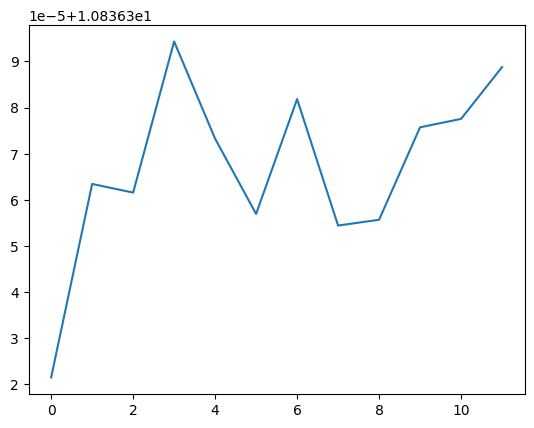

In [37]:
from matplotlib import pyplot as plt

plt.plot(losses)

In [38]:
# Save model
torch.save(transformer.state_dict(), "transformer.pth")

In [47]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained transformer model
transformer.eval()

# Get an example from the train_dataset
example = next(iter(dataset_train))

# Prepare the example for inference
src = example['text'].unsqueeze(0).to(device)
tgt = src.clone().to(device)
src_mask, tgt_mask = create_mask(src, tgt)
src_mask, tgt_mask = None, None
# src_mask, tgt_mask = src_mask.to(device), tgt_mask.to(device)

# Perform inference
with torch.no_grad():
    out = transformer(src, tgt, src_mask, tgt_mask)

# Decode the output
decoded_output = tokenizer.decode(out.squeeze(0).squeeze(0).argmax(dim=-1))

# Pretty print (keep the text to max 80 cols before adding new lines)
import textwrap

# Input
print("Input:")
print("\n".join(textwrap.wrap(tokenizer.decode(example['text'].squeeze(0)), 80)))
# Output
print("\nOutput:")
print("\n".join(textwrap.wrap(decoded_output, 80)))


Input:
It is done, and submitted. You can play “Survival of the Tastiest” on Android,
and on the web. Playing on the web works, but you have to simulate multi-touch
for table moving and that can be a bit confusing.  There’s a lot I’d like to
talk about. I’ll go through every topic, insted of making the typical what went
right/wrong list.  Concept  Working over the theme was probably one of the
hardest tasks I had to face.  Originally, I had an idea of what kind of game I
wanted to develop, gameplay wise – something with lots of enemies/actors, simple
graphics, maybe set in space, controlled from a top-down view. I was confident I
could fit any theme around it.  In the end, the problem with a theme like
“Evolution” in a game is that evolution is unassisted. It happens through
several seemingly random mutations over time, with the most apt permutation
surviving. This genetic car simulator is, in my opinion, a great example of
actual evolution of a species facing a challenge. But is it a 

/home/rnud/portfolio/notebooks/.venv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
